# What is the role of the media coverage in explaining stock market fluctuations ?

### Imports

In [1]:
import numpy as np
from util.dataloader import *
from util.finance import *
from util.plots import *
from util.quotebankexploration import *
from util.wikipedia import *
from util.apple_stores import *
from util.predictive_model import *
import plotly.io as pio

%load_ext autoreload
%autoreload 2

In [2]:
pio.renderers.default = "notebook_connected"

# <a class="anchor" id="TOC"></a> Table of Contents

***

* 0. [Introduction](#intro)
* 1. [Loading the datasets](#sect_1)
    * 1.1 [Apple stock : yFinance API](#sect_1_1)
    * 1.2 [Quotebank dataset](#sect_1_2)
* 2. [First look into the Apple stock market and related quotes](#sect_2)
    * 2.1 [Observations on the volatility, liquidity traded and media discussion](#sect_2_1)
    * 2.1 [Finding patterns and studying correlated features](#sect_2_2)
* 3. [Sentiment Analysis of Apple related quotes](#sect_3)
    * 3.1 [Sentiment Prediction](#sect_3_1)
    * 3.2 [Sentiment and stock liquidity](#sect_3_2)
* 4. [Impact of the number of pageviews on the speakers' Wikipedia page](#sect_4)
    * 4.1 [Wiki labels and wiki ID](#sect_4_1)
    * 4.2 [Number of wiki page views](#sect_4_2)
    * 4.3 [Exact label for each quotes](#sect_4_3)
    * 4.4 [Scoring quotes](#sect_4_4)
    * 4.5 [Get back sentiment analysis](#sect_4_5)
    * 4.6 [Final scoring](#sect_4_6)
    * 4.7 [Final plot](#sect_4_7)
* 5.  [Building a model for stock market prediction](#sect_5)
    * 5.1 [Model fitting and observations](#sect_5_1)
    * 5.2 [Model validation](#sect_5_2)

# 0. Introduction <a class="anchor" id="intro"></a>
[Back to table of contents](#TOC)

***

This notebook is intended to show and demonstrate the thought process that went into this project, on identifying patterns and correlations in the stock market and media quotes. In particular we have focused on the Apple Stock market, as it is one of the most valuable company on earth and it is widely covered in the media. 

# 1. Loading the datasets <a class="anchor" id="sect_1"></a>
[Back to table of contents](#TOC)

***

In this project we have studied three datasets to provide more insights in the stock price evolution, the coverage of Apple in the media, and its relationship with the various speakers. This first session is dedicated to loading the various datasets and preprocessing the valuable informations.

### 1.1 Apple stock : yFinance API <a class="anchor" id="sect_1_1"></a>
[Back to table of contents](#TOC)

The yFinance API is provided by Yahoo Finance and provides an easy access to various financial metrics for most stocks in the market. The _ticker_ of the Apple stock is denoted _AAPL_, and we will first focus on a date range from 2008 up to 2020. We also provide an additional indicator of the daily volatility with the ``Liquidity`` field, which is the daily volume multiplied by the average daily stock price. This indicator in dollars is appropriate to have a quick overview on the quantity of Apple stock traded in a day, as a day of high liquidity is also said to be a day of high volatility. 

In [3]:
# Using yFinance API we load various metrics of the Apple stock ranging from 2008 to 2020
stock = load_stock("AAPL", 2008, 2020)

# We set a day of high volatility as a day among the highest 2% of liquidity in that year.
stock = high_volatility(stock, quantile = 0.98)

display(stock)

Date       Open       High        Low      Close  Adj Close  \
0    2008-09-02   6.157143   6.196429   5.892857   5.935357   5.088768   
1    2008-09-03   5.958571   6.024286   5.857143   5.962857   5.112346   
2    2008-09-04   5.923571   5.996786   5.743214   5.757857   4.936586   
3    2008-09-05   5.663929   5.800000   5.630357   5.720714   4.904741   
4    2008-09-08   5.877500   5.888929   5.409286   5.640000   4.835539   
...         ...        ...        ...        ...        ...        ...   
2951 2020-05-22  78.942497  79.807503  78.837502  79.722504  78.955231   
2952 2020-05-26  80.875000  81.059998  79.125000  79.182503  78.420425   
2953 2020-05-27  79.035004  79.677498  78.272499  79.527496  78.762085   
2954 2020-05-28  79.192497  80.860001  78.907501  79.562500  78.796761   
2955 2020-05-29  79.812500  80.287498  79.117500  79.485001  78.720001   

          Volume     Liquidity Yearly Percentile  
0      780763200  4.720690e+09         Lower 98%  
1      734834800  4.380140e+09         Lower 98%  
2      743386000  4.341905e+09         Lower 98%  
3      786884000  4.479197e+09         Lower 98%  
4     1045979200  6.023533e+09         Lower 98%  
...          ...           ...               ...  
2951    81803200  6.489652e+09         Lower 98%  
2952   125522000  1.004537e+10         Lower 98%  
2953   112945200  8.954437e+09         Lower 98%  
2954   133560800  1.060172e+10         Lower 98%  
2955   153532400  1.222866e+10         Lower 98%  

[2956 rows x 9 columns]

### 1.2 Quotebank Dataset <a class="anchor" id="sect_1_2"></a>
[Back to table of contents](#TOC)

The Quotebank data is a large text corpus of more than 178 million quotations scrapped over 337 websites. As we are focusing on Apple related quotations, we have applied a various amount of filtering to reduce the number of quotes to 310'816. Some of the various techniques employed are: 
1. White list of words that should be contained in quotes : _Apple_, _iPhone_, _Macbook_ etc.
2. Black list of words that should not be contained : _Mac n Cheese, _apple_, _Big Apple_ etc.
3. White list of speakers, as we also included speakers related to Apple regardless of the aforementioned white words : _Steve Jobs_, _Tim Cook_, _Steve Wozniak_ etc.

This final dataset of Apple related quotes has been saved in a `pkl` file to improve the ease of manipulation, and can be accessed with the `get_filtered_quotes` function.

In [4]:
quotes = get_filtered_quotes()

display(quotes)

quoteID                                          quotation  \
0       2008-10-15-012147               five times the graphics performance.   
1       2008-09-25-038377  my iphone is full of pictures. i wanted to see...   
2       2008-09-04-052789  the people who connect needs and ideas the bes...   
3       2008-11-10-038937  sesame workshop will get 70 percent of the rev...   
4       2008-09-26-048683  the huge success of the apple itunes app store...   
...                   ...                                                ...   
310811  2020-03-06-004716  Apple continues to show their tremendous suppo...   
310812  2020-01-21-010221  But at the same time, we're also not saying th...   
310813  2020-01-22-079970  The Big Mac burger sauce is so hard to get hol...   
310814  2020-04-01-004824  Archie has been loving doing FaceTime playdate...   
310815  2020-01-29-066743  No new office, no iPad -- just democracy in ac...   

                 speaker                             qids                date  \
0             steve jobs                         [Q19837] 2008-10-15 06:38:46   
1         ken whisenhunt                       [Q1758635] 2008-09-25 08:08:08   
2             steve jobs                         [Q19837] 2008-09-04 18:19:47   
3       robert macmillan           [Q21453558, Q28094302] 2008-11-10 22:59:44   
4           steve howard  [Q23670647, Q2457386, Q7612886] 2008-09-26 11:29:23   
...                  ...                              ...                 ...   
310811              none                               [] 2020-03-06 01:14:31   
310812     satya nadella                       [Q7426870] 2020-01-21 15:44:24   
310813              none                               [] 2020-01-22 12:34:13   
310814              none                               [] 2020-04-01 12:14:50   
310815  heather anderson           [Q15463471, Q30041417] 2020-01-29 10:33:00   

        numOccurrences                                             probas  \
0                    2             [[steve jobs, 0.7707], [None, 0.2293]]   
1                    1  [[ken whisenhunt, 0.3759], [None, 0.3186], [ma...   
2                    1               [[steve jobs, 0.717], [None, 0.283]]   
3                    1       [[robert macmillan, 0.6071], [None, 0.3929]]   
4                    1           [[steve howard, 0.5034], [None, 0.4966]]   
...                ...                                                ...   
310811               2  [[None, 0.6748], [Octavia Spencer, 0.2615], [M...   
310812               1          [[Satya Nadella, 0.8487], [None, 0.1513]]   
310813               2                [[None, 0.8268], [Big Mac, 0.1733]]   
310814               1  [[None, 0.6707], [Prince Harry, 0.2197], [Megh...   
310815               1       [[Heather Anderson, 0.8361], [None, 0.1639]]   

                                                     urls phase  
0       [http://us.rd.yahoo.com/dailynews/rss/search/m...     A  
1       [http://azcentral.com/arizonarepublic/sports/a...     A  
2       [http://businessweek.com/magazine/content/07_4...     A  
3       [http://macdailynews.com/index.php/weblog/comm...     A  
4       [http://ipod.consumerelectronicsnet.com/articl...     A  
...                                                   ...   ...  
310811  [https://www.denofgeek.com/tv/truth-be-told-se...     E  
310812  [https://www.theverge.com/2020/1/21/21071108/m...     E  
310813  [https://www.mirror.co.uk/money/shopping-deals...     E  
310814  [https://www.pinkvilla.com/entertainment/holly...     E  
310815  [http://express.co.uk/news/politics/1234935/br...     E  

[310816 rows x 9 columns]

# 2. First look into the Apple stock market and related quotes <a class="anchor" id="sect_2"></a>
[Back to table of contents](#TOC)

One objective of this project is to find patterns and events in both the stock market and media discussion related to Apple.

***

### 2.1 Observations on the volatility, liquidity traded and media discussion <a class="anchor" id="sect_2_1"></a>
[Back to table of contents](#TOC)

In order to do so, we need metrics and qualitative visualization of the aforementioned data. To find days of interest in the stock market, we introduce the _Liquidity_, which is the mean price day multiplied by the daily volume of exchange. This indicator provides an intuition of the amount of $AAPL stock exchanged in day. A day of high liquidity will be synonymous of a day of high volatility, which may indicate a particular event related to Apple.

In the following plot we highlight the yearly top 2% of the liquidity days. In other words, we will observe each year the days with the highest liquidity. We observe a pattern that will be further studied, as the iPhone september events, or the quarterly reports. 

In [5]:
weekly_liquidity(stock, quantile=0.98)

Naturally we proceed to this comparison of high exchange days by looking at the daily price of the $AAPL stock. We highlight the same days of high volatility from the previous figures but next to the stock price instead of the liquidity. The intuition is that a day of high volatility may have repercussions on the stock price, either as a price fall or a rebound. 

In [6]:
daily_stock_price(stock)

Finally we will take a look at the filtered Quotebank dataset, which only describes Apple related quote. In the same idea as previous plots, we can highlight the yearly top 2% of days with the most quotes. Again we can observe some patterns, that will be further dissected in the next few sections. For example we observe a yearly spike in September when the new iPhone is released, or in June with the yearly developer conference. Most importantly the highest spike the 6th October 2011 is related to Steve Jobs death, which was widely covered in the media.

In [7]:
daily_quotes(quotes, quantile = 0.98)

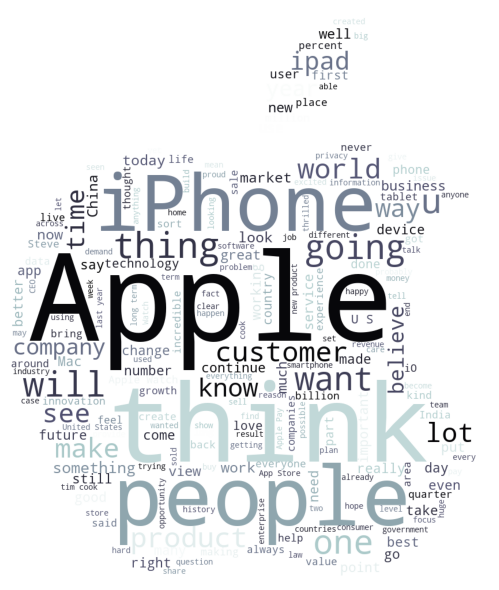

In [8]:
plot_wordcloud(' '.join(quotes[quotes.speaker == "tim cook"].quotation).split(" "), mask = True)

### 2.2 Finding patterns and studying correlated features <a class="anchor" id="sect_2_2"></a>
[Back to table of contents](#TOC)

From the above observations, we had the intuition that each quarter report released by Apple was synonymous with a day of high volatility. A quarterly report is a summary or collection of unaudited financial statements, such as  gross revenue, net profit, operational expenses, and cash flow. As we have 252 trading days in a year and 4 quarter reports per year, we expect a periodicity of high liquidity days of around $252/4 = 64$ days. This in fact validated by the next cell, which performs a seasonal analysis over a wide range of days period, and keeps the days with the lowest null probability (i.e p-value). Later on we will see if this pattern is also observable on the Apple related quotes.

In [9]:
seasonal_analysis(stock[stock.Date.dt.year.isin([2018,2019])], column="Liquidity")

100%|██████████| 120/120 [00:02<00:00, 50.34it/s]


The Liquidity can be fitted with a seasonal model of period 64 with p_value 6.639388969749278e-28


What we finally observe is that there is a qualitative correlation between the number of daily quotes related to Apple and the daily liquidity. The two are positively correlated (the Pearson correlation coefficient is approximately 0.3 and the p-value is very small), which indicates that an increase in liquidity will be likely associated with an increase in discussion related to Apple and the other way around. 

In [10]:
stock_price_with_quotes(stock,quotes)

In [11]:
pearson_stock_quotes(stock[stock.Date.dt.year.isin(range(2015,2019))],quotes)

(0.315489221804481, 8.207856553749298e-24)

# 3. Sentiment Analysis of Apple related quotes <a class="anchor" id="sect_3"></a>
[Back to table of contents](#TOC)

***

### 3.1 Sentiment Prediction <a class="anchor" id="sect_3_1"></a>
[Back to table of contents](#TOC)

One further study that we can perform on the set of quotes related to Apple is a sentimental analysis. Performing a sentiment distinction on the quotes may be useful to understanding the semantic orientation during a period of time, and find events of interest. We will use [VADER](https://www.nltk.org/howto/sentiment.html), a lexicon and rule based sentiment analysis tool that can classify each quote in either positive, neutral or negative intent. More precisely, this predictive model gives a score in a $[-1,1]$ range, with $1$ being very positive, $-1$ very negative and $0$ neutral sentiment. In this section we will look at the correlation between the semantic content of those quotes and the actual stock price.


In [12]:
quotes_sentiments = predict_sentiment(quotes)

### 3.2 Sentiment and stock liquidity <a class="anchor" id="sect_3_2"></a>
[Back to table of contents](#TOC)

Furthermore we can qualitatively estimate the correlation between distinct sentiments and the observed market liquidity. Just as seen in the previous section, we will compute the Pearson correlation between either the positive, negative or neutral quotes and the liquidity. As we found a correlation value of 0.3154 with all quotes regardless of the sentiment, here we expect to observe a lower score for negative quotes rather than positive or neutral. 



In [13]:
correlation_stock_sentiment(quotes_sentiments,stock)

Pearson positive (0.2146146024348949, 6.647184376858403e-31)
Pearson negative (0.16531231857287215, 1.8448365209536944e-18)
Pearson neutral (0.21925480669193834, 7.580016059373651e-32)


Looking at the computed correlations, we have indeed a lower correlation score of 0.1653 for negative quotes, compared to 0.2146 and 0.2192 for positive or neutral quotes. As all those values are positive, we may say that regardless of the sentiment, an increase in the number of quotations is most likely associated with an increase in liquidity and volatility of the Apple stock. Most importantly we observe that positive quotes have a greater correlation than negative quotes. One hypothesis that we may establish is that while negative quotes may make it more likely to sell a higher volume of stocks than usual, positive quotes have higher influence on the volatility and the market may be more willing to buy more stocks.


In [14]:
fig_all_sentiments(quotes_sentiments,stock)

# 4. Impact of the number of pageviews on the speakers' Wikipedia page <a class="anchor" id="sect_4"></a>
[Back to table of contents](#TOC)

***

Previously, we have looked at the impact of the valence of the different quotes related to Apple on the stock market. Let's add more depth to our analysis of the impact of the media on the stock market. What is the impact of the speaker of a quote? The response is relatively simple, it depends on how well known the speaker was at the time he or she was quoted in the media. And a quite simple way to measure this is to use the number of pageviews on the speakers' Wikipedia page (if there is one!).

#### 4.1 Wiki labels and wiki ID <a class="anchor" id="sect_4_1"></a>
[Back to table of contents](#TOC)

Before accessing to the pageviews statistics, we need the exact label of the speakers' Wikipedia page. For this purpose, we load the following data set which links each speaker to its Wikipedia page.

In [15]:
# Get the wiki labels with its corresponding wiki ID
wiki_labels = get_wiki_labels()[['id', 'label']]
display(wiki_labels.head(5))

id              label
0    Q23  George Washington
1    Q42      Douglas Adams
2  Q1868         Paul Otlet
3   Q207     George W. Bush
4   Q297    Diego Velázquez

#### 4.2 Number of wiki page views <a class="anchor" id="sect_4_2"></a>
[Back to table of contents](#TOC)

After that, we need a way to get the number of pageviews of the speakers annually. We use the package `pageviewapi` which gives us all the wiki page views since 2015. We would have liked to have all the pageviews since 2008, but it was too complicated. Indeed one person has created a way to get these data, but the website did not work anymore. Thus, we focused our study between 2015 and 2020, and we designed a function which returns the number of pageviews for a specific wiki page and year.

In [16]:
# Get the page views for the Steve Jobs wikipedia page in 2015
speaker = 'Steve Jobs'
year = 2015
print(get_page_views_per_year(speaker, year))

6365607


#### 4.3 Exact label for each quote <a class="anchor" id="sect_4_3"></a>
[Back to table of contents](#TOC)

The idea now is to get the exact label of each speaker for every quotes. However, the different quotes can have more than one QID! Indeed, sometimes the name of the speaker for a specific quote can be confused with another speaker, so it gives two QID in the list for that quote! To deal with this issue, we decided to look at all the different QID for each quote, and we kept the label which corresponds to the speaker having the maximum number of total pageviews. 

Before that, we recover all the speakers' ID for all the quotes that are not anonymous.

In [17]:
# Get the speakers' ID
speakers_id = get_speakers_ids(quotes)
speakers_id_sample = speakers_id.head(5)
display(speakers_id_sample)

speaker                                               qids
0        steve jobs                                           [Q19837]
1    ken whisenhunt                                         [Q1758635]
2  robert macmillan                             [Q21453558, Q28094302]
3      steve howard                    [Q23670647, Q2457386, Q7612886]
4       doug martin  [Q18685889, Q27995830, Q3037945, Q3714598, Q53...

Here we can clearly see that for one speaker, there might be more than one QID. Thus, in the following cell, we recover for all the speakers the true label in Wikipedia, i.e. the one for which the number of pageviews is the highest.

**Remark :** The following cell shows how the process is done over a sample of the full dataframe `quotes`. We are not doing the whole filtering below because the run is about 22h. Thus, we have done it once on multiple clusters and have saved the results in a pickle file.

In [18]:
# Get the right label of the speakers of each quotes.
# It adds a new column `label` in quotes dataframe containig the wiki label of the speaker.
speakers_labels_sample = find_labels(speakers_id_sample, wiki_labels)
display(speakers_labels_sample)

# Get the whole data set from a .pkl file
speakers_labels = get_speakers_labels()

100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


speaker                                               qids  \
0        steve jobs                                           [Q19837]   
1    ken whisenhunt                                         [Q1758635]   
2  robert macmillan                             [Q21453558, Q28094302]   
3      steve howard                    [Q23670647, Q2457386, Q7612886]   
4       doug martin  [Q18685889, Q27995830, Q3037945, Q3714598, Q53...   

              label  
0        Steve Jobs  
1    Ken Whisenhunt  
2  Robert MacMillan  
3      Steve Howard  
4       Doug Martin

#### 4.4 Scoring quotes <a class="anchor" id="sect_4_4"></a>
[Back to table of contents](#TOC)

Now we have the exact label of the speaker for every quotes. In the following, we want to get the wikipedia page views statistics for every speakers at the year where the quote was published. We take the label and the year of each quotes and use the function `get_pageviews_per_year` to add a new column `score` in our data frame.

**Remark :** As in the previous subsection, here is an example of how the process works on a small sample of the data set because the run for the whole data set is too long (around 8h for this one). Since the runnning time is so long, we decided to split the steps such that we can run it on multiple computer. Eventually, we were able to get the number of pageviews for each speaker for every year between 2015 and 2020. Here is an example of how the code works.

In [19]:
# Apply the process on a small sample
speakers_pageviews_sample = get_speakers_pageviews_per_year(speakers_labels_sample)
display(speakers_pageviews_sample)

# Load the whole data set from a pickle file
speakers_pageviews = get_speakers_pageviews()

speaker                                               qids  \
0        steve jobs                                           [Q19837]   
1    ken whisenhunt                                         [Q1758635]   
2  robert macmillan                             [Q21453558, Q28094302]   
3      steve howard                    [Q23670647, Q2457386, Q7612886]   
4       doug martin  [Q18685889, Q27995830, Q3037945, Q3714598, Q53...   

              label     2015     2016     2017     2018     2019     2020  
0        Steve Jobs  6365607  9536391  7605088  6458359  6362619  6900472  
1    Ken Whisenhunt   135492   115367    86274   132915   113473    81236  
2  Robert MacMillan      498     1111      946      884      835     1152  
3      Steve Howard     9700    23643    19157    17095    18213    21539  
4       Doug Martin     3276     6785     3220     6103     1841     1242

Now, we directly join the year of the quotes with the corresponding number of pageviews of the speakers. After that we normalize the value and we then obtain a score for each quotes (in absolute value for now).

**Remark :** The process here does not use the `pageviewapi` package, so it is pretty fast then we can directly do it on the whole data frame.

In [20]:
# Add score column for our data frame
quotes_score = get_score_quotes(quotes, speakers_pageviews)
display(quotes_score.head(5))

speaker            quoteID  \
0   2 chainz  2018-09-10-038202   
1  21 savage  2016-12-13-038368   
2  21 savage  2017-09-26-146262   
3     30 roc  2020-01-28-077235   
4    50 cent  2015-03-31-013537   

                                           quotation    qids_left  \
0  I want to send condolences to Mac Miller's fam...    [Q129668]   
1  I got more followers & more shooters than the ...  [Q25095399]   
2  We just have a long history of supporting Post...  [Q25095399]   
3  The day after the album came out, I went on iT...  [Q50352763]   
4  Do we want to release the single on iTunes fir...      [Q6060]   

                 date  numOccurrences  \
0 2018-09-10 11:44:18               1   
1 2016-12-13 19:55:57               1   
2 2017-09-26 14:04:09               1   
3 2020-01-28 19:17:20               5   
4 2015-03-31 16:20:43               1   

                                              probas  \
0  [[2 Chainz, 0.8386], [None, 0.1492], [Mac Mill...   
1  [[21 Savage, 0.6807], [None, 0.2981], [Kylie J...   
2  [[21 Savage, 0.4937], [None, 0.2597], [DJ Khal...   
3                 [[30 Roc, 0.8062], [None, 0.1938]]   
4                  [[50 Cent, 0.908], [None, 0.092]]   

                                                urls phase   qids_right  \
0  [https://rollingout.com/2018/09/10/2-chainz-cl...     E    [Q129668]   
1  [http://urbanislandz.com/2016/12/13/21-savage-...     E  [Q25095399]   
2  [https://forums.macrumors.com/threads/rapper-p...     E  [Q25095399]   
3  [http://ctpost.com/entertainment/article/Hitma...     E  [Q50352763]   
4  [http://www.thecrimson.com/article/2015/3/31/k...     E      [Q6060]   

       label  pageviews     score  
0   2 Chainz      761.0  0.000003  
1  21 Savage  1042616.0  0.004614  
2  21 Savage     2302.0  0.000010  
3     30 Roc  1198574.0  0.005304  
4    50 Cent  2051341.0  0.009077

#### 4.5 Get back to sentiment analysis <a class="anchor" id="sect_4_5"></a>
[Back to table of contents](#TOC)

Now we have an absolute score value for each single quote which is a way to represent the notoriety of the speaker. Can we combine this information with the sentiment analysis for each quote used in the previous section? We will use again the function designed in the section 3.4 to get the valence of each quote (+1 for positive, -1 for negative and 0 for neutral). In the following cell, we show how the process works to add a column `sentiment` to our dataframe.

In [21]:
# Add the column sentiment
quotes_sentiment = get_sentiment_quotes(quotes_score)
display(quotes_sentiment.head(5))

100%|██████████| 128672/128672 [00:20<00:00, 6331.88it/s] 


speaker            quoteID  \
0   2 chainz  2018-09-10-038202   
1  21 savage  2016-12-13-038368   
2  21 savage  2017-09-26-146262   
3     30 roc  2020-01-28-077235   
4    50 cent  2015-03-31-013537   

                                           quotation    qids_left  \
0  I want to send condolences to Mac Miller's fam...    [Q129668]   
1  I got more followers & more shooters than the ...  [Q25095399]   
2  We just have a long history of supporting Post...  [Q25095399]   
3  The day after the album came out, I went on iT...  [Q50352763]   
4  Do we want to release the single on iTunes fir...      [Q6060]   

                 date  numOccurrences  \
0 2018-09-10 11:44:18               1   
1 2016-12-13 19:55:57               1   
2 2017-09-26 14:04:09               1   
3 2020-01-28 19:17:20               5   
4 2015-03-31 16:20:43               1   

                                              probas  \
0  [[2 Chainz, 0.8386], [None, 0.1492], [Mac Mill...   
1  [[21 Savage, 0.6807], [None, 0.2981], [Kylie J...   
2  [[21 Savage, 0.4937], [None, 0.2597], [DJ Khal...   
3                 [[30 Roc, 0.8062], [None, 0.1938]]   
4                  [[50 Cent, 0.908], [None, 0.092]]   

                                                urls phase   qids_right  \
0  [https://rollingout.com/2018/09/10/2-chainz-cl...     E    [Q129668]   
1  [http://urbanislandz.com/2016/12/13/21-savage-...     E  [Q25095399]   
2  [https://forums.macrumors.com/threads/rapper-p...     E  [Q25095399]   
3  [http://ctpost.com/entertainment/article/Hitma...     E  [Q50352763]   
4  [http://www.thecrimson.com/article/2015/3/31/k...     E      [Q6060]   

       label  pageviews     score  sentiment  
0   2 Chainz      761.0  0.000003          1  
1  21 Savage  1042616.0  0.004614         -1  
2  21 Savage     2302.0  0.000010          1  
3     30 Roc  1198574.0  0.005304         -1  
4    50 Cent  2051341.0  0.009077          1

#### 4.6 Final scoring <a class="anchor" id="sect_4_6"></a>
[Back to table of contents](#TOC)

Finally, we multiply the valence of the quotes with the absolute score to get a positive and negative score. So we first create two columns `negative_score` and `positive_score` for each quote. 

**Example :** If the quote has a negative valence, in column `negative_score` there will be the valence (-1) multiplied with the absolute score and in the column `positive_score` the value will be equal to zero.

In [22]:
# Add positive and negative score
quotes_neg_pos_score = get_neg_pos_score_quotes(quotes_sentiment)
display(quotes_neg_pos_score.head(5))

speaker            quoteID  \
0   2 chainz  2018-09-10-038202   
1  21 savage  2016-12-13-038368   
2  21 savage  2017-09-26-146262   
3     30 roc  2020-01-28-077235   
4    50 cent  2015-03-31-013537   

                                           quotation    qids_left  \
0  I want to send condolences to Mac Miller's fam...    [Q129668]   
1  I got more followers & more shooters than the ...  [Q25095399]   
2  We just have a long history of supporting Post...  [Q25095399]   
3  The day after the album came out, I went on iT...  [Q50352763]   
4  Do we want to release the single on iTunes fir...      [Q6060]   

                 date  numOccurrences  \
0 2018-09-10 11:44:18               1   
1 2016-12-13 19:55:57               1   
2 2017-09-26 14:04:09               1   
3 2020-01-28 19:17:20               5   
4 2015-03-31 16:20:43               1   

                                              probas  \
0  [[2 Chainz, 0.8386], [None, 0.1492], [Mac Mill...   
1  [[21 Savage, 0.6807], [None, 0.2981], [Kylie J...   
2  [[21 Savage, 0.4937], [None, 0.2597], [DJ Khal...   
3                 [[30 Roc, 0.8062], [None, 0.1938]]   
4                  [[50 Cent, 0.908], [None, 0.092]]   

                                                urls phase   qids_right  \
0  [https://rollingout.com/2018/09/10/2-chainz-cl...     E    [Q129668]   
1  [http://urbanislandz.com/2016/12/13/21-savage-...     E  [Q25095399]   
2  [https://forums.macrumors.com/threads/rapper-p...     E  [Q25095399]   
3  [http://ctpost.com/entertainment/article/Hitma...     E  [Q50352763]   
4  [http://www.thecrimson.com/article/2015/3/31/k...     E      [Q6060]   

       label  pageviews     score  sentiment  positive_score  negative_score  
0   2 Chainz      761.0  0.000003          1        0.000003        0.000000  
1  21 Savage  1042616.0  0.004614         -1        0.000000        0.004614  
2  21 Savage     2302.0  0.000010          1        0.000010        0.000000  
3     30 Roc  1198574.0  0.005304         -1        0.000000        0.005304  
4    50 Cent  2051341.0  0.009077          1        0.009077        0.000000

Then, we sum the score every day. The idea is to identify the days for which a lot of famous people have talked about Apple positively or negatively. We keep only the columns `date`, `positive_score` and `negative_score` for the final plot. The following cell shows how the process is applied.

In [23]:
# Get the negative and positive scores for every days
score_date = get_score_date(quotes_neg_pos_score)
display(score_date.head(5))

date  positive_score  negative_score
0  2015-01-01        0.000079        0.007516
1  2015-01-02        0.012737        0.003240
2  2015-01-03        0.005720        0.028335
3  2015-01-04        0.002935        0.000000
4  2015-01-05        0.009968        0.011739

In [24]:
correlation_stock_fame(score_date,stock)

Pearson positive score : (0.022961431592596077, 0.4113951101407043)
Pearson negative score : (-0.032305996895011534, 0.2477259632706098)


#### 4.7 Final plot <a class="anchor" id="sect_4_7"></a>
[Back to table of contents](#TOC)

After all these steps, we can finally have a concrete visualization of our results. We plot the `positive_score` and the `negative_score` depending of the `date`. In addition, we plot on the same figure the Apple stock price depending also of the `date`. The goal is to see if there is a visible correlation betwen the positive and negative scores and the stock price. Here is the following plot.

In [25]:
stock_price_against_quotes_score(score_date, stock)

#### 4.8 Distribution of the quotes according to their valence and to the fame of the speaker <a class="anchor" id="sect_4_8"></a>
[Back to table of contents](#TOC)

In the following plot, we just wanted to visualize the distribution of the quotes according to their valence and to the fame of the speaker. We have chosen 6 events which were highly mediatized between 2015 and 2020. We chose 6 major events picked up from the 2% in this plot for which we were able to find relevant thematic associated e.g. the “FBI-Apple encryption dispute”, “Release of the iPhone X”, etc. Quotations were plotted according to their valence and to the fame of their speaker.

In [26]:
plot_distrib_val_fame(quotes_sentiment)

100%|██████████| 128672/128672 [00:19<00:00, 6759.86it/s] 


----
# 5. Building a model for stock market prediction <a class="anchor" id="sect_5"></a>
[Back to table of contents](#TOC)

Using the quotes related to Apple, speakers data and past stock performance, we can perform a first attempt at predicting the daily stock price and the liquidity. For this section we will use the Facebook's Prophet library, which provides powerful and easy to use forecasting tools. At its core, the model is a modular linear regression model, that can take into account past performance and additional factors. 

**Remark**: Prophet use a python translation layer of Ctan, and as the unresolved issue of printing all the Ctan computation iterations, and in the current state of the library there is no way to hide those outputs.

### 5.1 Model fitting and observations <a class="anchor" id="sect_5_1"></a>
[Back to table of contents](#TOC)

In this final section we will attempt to train a time series forecasting model using the previous stock price and the score obtained in the previous section. We recall that this sentiment score is obtained using the number of wikipedia views for the speaker and the sentiment of their quote. As the wikipedia data only goes back as far as 2015, we will limit this section there. Furthermore we have observed in 2019 a [stock split](https://www.investopedia.com/terms/s/stocksplit.asp), which is when a company divides the price of a stock but multiply the amount of available shares by the same factor. This sudden price fall was unpredictable and does not indicate a pullback from the overall market. This unusual data is why we will limit this section from 2015 to 2017. Finally we will fit the model on 2017 and observe its prediction on 2018, compared to the actual price in 2019.

In [27]:
# Build the prediction frame of stocks and sentiment features
quotes_sentiment = pd.read_pickle("data/quotes_score.pkl")
prediction_frame = build_prediction_frame(stock[stock.Date.dt.year.isin(range(2015,2018))],quotes_sentiment)

# Initialize the Prophet model and fits it with the prediction frame 
m = fit_prophet(Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=0.1), prediction_frame, features=['positive','negative','total'], response='Open')
pred = predict_future(m,prediction_frame,feature_frame = quotes_sentiment)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.96009
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2177.66     0.0201062       1690.21           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2206.4   0.000919472       302.524      0.2468      0.2468      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219        2208.5   5.93025e-05       91.5172   4.022e-07       0.001      300  LS failed, Hessian reset 
     299       2212.57   0.000581259        134.91           1           1      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       2215.71   0.000100249       166.165   6.682e-07       0.001      560  LS failed, Hessian reset 
     399       2215.72   7.41759e-05       135.286           1           1      561   
    Iter      log pro

On the graph bellow, we can observe the fitted model on the 2015 to 2017 range, and its prediction on the 2019. First  we observe that the true stock price in the first quarter of 2018 is quite below the predicted lower bound. However the model successfully predicts a price fall in July 2018, and from there the true price comes back to the prediction range. This first attempt for a model provides interesting insights in the periodicity of the data and shows that the additional feature indeed contribute to the model.

In [28]:
plot_prediction(stock, quotes_sentiment,pred)

### 5.2 Model validation <a class="anchor" id="sect_5_2"></a>
[Back to table of contents](#TOC)

To validate the parameters and formulation of our model, we will perform time series cross validation. The idea is to start with a model fitted on the first 150 days, predict the stock price on the following 60 days and evaluate the error. Once this first fold is done, we add the next 30 days of the original 150 days to the training frame, and predict again on the following 60 days. This will be  illustraded on the below figure.

<center><img src="../figures/val.png"/></center>

We will evaluate the mean absolute percentage of error, which provides the average percentage of error one can expect using the model to predict the stock price.
$$MAPE =\frac{100 \%}{n} \sum_{t=1}^{n}\left|\frac{A_{t}-F_{t}}{A_{t}}\right| $$

We observed a MAPE of 0.04226, which means that using these model one should expect a prediction difference of 4.226% compared to the actual price.

In [29]:
# Performance evaluation
df_cv = cross_validation(m, initial='150 days', period='30 days', horizon = '60 days',parallel="processes")
df_p = performance_metrics(df_cv)

print("Mean absolute percentage error in a first week horizon", df_p["mape"].values[0])


INFO:prophet:Making 30 forecasts with cutoffs between 2015-06-13 00:00:00 and 2017-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa0dfbdc310>


Initial log joint probability = -2.71142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.87665
Initial log joint probability = -2.25054
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       781.674   2.40472e-06       96.6519      0.5036      0.5036      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       513.757   0.000995922       208.189      0.8655      0.8655      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       622.716   1.82659e-06       100.881       0.743       0.743      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       781.706   0.000182345       165.029   1.099e-06  

      99       1176.73    0.00466726       400.413      0.9336      0.9336      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       987.688   4.49268e-06       26.3682      0.3593      0.3593     1667   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1042.93    7.3059e-05       54.0789      0.5595      0.5595     1053   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1143.29    0.00011526        82.707      0.9736      0.9736      712   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     917       987.689   7.58389e-06       74.7272   1.226e-07       0.001     1735  LS failed, Hessian reset 
     931       987.689    1.2152e-07       44.6412      0.9575     0.05355     1759   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude

### 5.3 Fine tunning the parameters
[Back to table of contents](#TOC)

Finally we can use this cross validation technique to find what hyper parameters are expected to provide the best model on a test set. We will attempt to find better hyperparameters for two arguments of the prophet model:
1. `changepoint_prior_scale` : This parameter determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints.
2. `seasonality_prior_scale` : This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality.

In [30]:
# Parameters grids to evaluate
param_grid = {  
  'changepoint_prior_scale': np.linspace(0.2,2,3) ,
  'seasonality_prior_scale': np.logspace(-2,1,3),
}

# Performs cross validation
tuning_results = prophet_cross_validation(param_grid, stock, quotes_sentiment, metric = 'mape')

# Outputs the best parameters in terms of mean MAPE on validation set
tuning_results[tuning_results.mape == tuning_results.mape.min()]

  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 58 forecasts with cutoffs between 2015-06-12 00:00:00 and 2020-02-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9fb5590bb0>


Initial log joint probability = -14.5633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3364.05     0.0640954       1285.75           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3458.4     0.0250741       479.271           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3498.37      0.103136        512.71           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3548.51      0.782629       2754.51           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3603.4     0.0904297          1303           1           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 58 forecasts with cutoffs between 2015-06-12 00:00:00 and 2020-02-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9fb55833d0>


Initial log joint probability = -14.5633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3392.31     0.0569551       1197.64           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3461.15     0.0113321       334.252           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3508.88    0.00745737       118.596           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3548.58    0.00116782       262.738      0.3479      0.3479      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3592.44     0.0781883       1358.19           1           1      564   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 58 forecasts with cutoffs between 2015-06-12 00:00:00 and 2020-02-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9fb5583700>


Initial log joint probability = -14.5633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3390.96     0.0427299       1251.45      0.4125           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3459.99     0.0194788       152.546           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3478.54    0.00236283       97.0433           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3577.59     0.0708225       2362.22      0.2815           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3616.81      0.013969       416.233      0.6378      0.6378      578   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 58 forecasts with cutoffs between 2015-06-12 00:00:00 and 2020-02-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9fa67ab280>


Initial log joint probability = -14.5633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3386.51    0.00728976        497.68           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3484.17    0.00516896       486.124      0.7195      0.7195      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3570.9     0.0865179       450.397           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3661.56     0.0174629       335.613           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3678.13     0.0321474        987.61           1           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 58 forecasts with cutoffs between 2015-06-12 00:00:00 and 2020-02-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9fb5583910>


Initial log joint probability = -14.5633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3430.75    0.00200723        430.98           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3520.97     0.0146717       1316.84      0.2455           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3542.19    0.00277462       356.926      0.4272      0.4272      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3592.71     0.0282096        1314.6           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3646.38     0.0221071       362.382           1           1      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 58 forecasts with cutoffs between 2015-06-12 00:00:00 and 2020-02-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9fb5586640>


Initial log joint probability = -14.5633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3408.06      0.183433       4978.68      0.2021           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3493.71      0.045603       909.727           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3550.57      0.109456       686.215           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3675.38      0.084008        1120.9           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3732.4      0.040712       721.345        0.43        0.43      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 58 forecasts with cutoffs between 2015-06-12 00:00:00 and 2020-02-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9fa67adbb0>


Initial log joint probability = -14.5633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3392.2    0.00374966       521.125           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3494.04    0.00350544        320.19           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3531.8    0.00269612       179.244           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3604.76    0.00419327       366.439           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3636.18     0.0222612       391.404           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 58 forecasts with cutoffs between 2015-06-12 00:00:00 and 2020-02-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9fb5583c70>


Initial log joint probability = -14.5633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3423.2     0.0127004       406.934           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3503.95     0.0232819       591.231           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3580.31     0.0342153        863.65           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3637.21     0.0482847       2411.63      0.6024      0.6024      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3690.45    0.00344164        451.83           1           1      557   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 58 forecasts with cutoffs between 2015-06-12 00:00:00 and 2020-02-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9fb5590df0>


Initial log joint probability = -14.5633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3393.2     0.0199882       456.697           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3508.96     0.0237777       1639.25       0.327           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3569.92     0.0191535       229.812           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3599.05    0.00402379       166.345           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3743.84    0.00111384       727.299      0.7398      0.7398      564   
    Iter      log prob        ||dx||      ||grad||       alpha  

changepoint_prior_scale  seasonality_prior_scale      mape
6                      2.0                     0.01  0.028463